# Problem Statement & Background

Proyek ini bertujuan untuk mengembangkan model analisis sentimen yang dapat mengklasifikasikan komentar Instagram secara otomatis ke dalam kategori positif dan negatif. Dengan memanfaatkan teknik Pemrosesan Bahasa Alami (NLP), kami bertujuan untuk menyediakan solusi yang kuat yang membantu dalam memahami sentimen pengguna, memungkinkan manajemen konten dan strategi keterlibatan pengguna yang lebih baik.

Datasets Source ( https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_komentar_instagram_cyberbullying.csv )

# Import Library

In [ ]:
#import library yang diperlukan
!pip install Sastrawi
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping
import string

nltk.download('stopwords')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Loading & Cleaning

In [ ]:
# mengambil data dari sumber
url = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv'
df = pd.read_csv(url)
print(df.head(5))


   Id Sentiment                             Instagram Comment Text
0   1  negative   <USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1   2  negative  Geblek lo tata...cowo bgt dibela2in balikan......
2   3  negative  Kmrn termewek2 skr lengket lg duhhh kok labil ...
3   4  negative  Intinya kalau kesel dengan ATT nya, gausah ke ...
4   5  negative  hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [ ]:
# menghapus kolom id dan mengganti nama kolom 'instagram comment text' menjadi 'text'
df.drop(['Id'], axis=1, inplace=True)
df.columns = ['sentiment', 'text']

In [ ]:
df['label'] = df['sentiment'].replace({'negative' : 0, 'positive' : 1})


## Stemming & Stopwords

In [ ]:
# Memproses teks dengan teknik stemming dan penghapusan kata-kata penghenti (stopwords)

# Menginisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Membuat list stopword
stpwrd = list(set(stopwords.words('indonesian')))
additional_stopword = ['gak', 'nya', 'bgt', 'banget', 'yg', 'lo', 'ya', 'ga', 'aja',
                      'org', 'orang', 'si', 'lu', 'udh','jdi', 'lgi', 'sih', 'jd', 'dy',
                      'arti', 'anak', 'ny', 'n', 'lg', 'tpi', 'kaya', 'udah', 'tau',
                      'moga', 'sdh', 'kalo', 'klo', 'aj', 'pny', 'krn', 'skrg', 'jg']
stpwrd.extend(additional_stopword)

## Text Processing

In [ ]:
# membuat function untuk preprocessing data
def text_processing(text):
  text = text.lower() #mengubah menjadi huruf kecil
  text = re.sub('\[.*?\]', ' ', text) # menghilangkan teks yang ada dalam kurung
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # menghilangkan tanda baca
  text = re.sub('\n', ' ', text) # menghilangkan \n
  teks = re.sub("[^A-Za-z\s']", " ", text) # Menghilangkan yang bukan huruf
  text = re.sub('\w*\d\w*', ' ', text) # menghilangkan angka
  text = re.sub('username', ' ', text) # menghapus kata 'username'
  tokens = word_tokenize(text)
  text = ' '.join([word for word in tokens if word not in stpwrd])
  text =' '.join(stemmer.stem(word) for word in text.split(" "))
  return text


In [ ]:
df['text_processed'] = df['text'].apply(lambda x: text_processing(x))
df

,sentiment,text,label,text_processed
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,0,tolol hubung gugur dgn pake hijab syar i bilan...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......,0,geblek tata cowo balik hadeww ntar tinggal nya...
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,0,kmrn skr lengket duhhh labil mbak kya abege aj...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",0,inti kesel att gausah anak kasi kembang psikis...
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",0,hadewwwww permpuan sakit jiwa knp peran utama ...
...,...,...,...,...
395,positive,Bangga sama suami yg selalu ingat istri disela...,1,bangga suami istri sela apa profesi kau juara ...
396,positive,Apaoun pekerjaannya yg penting halal u tuk men...,1,apaoun kerja halal u tuk nafkah keluarga semangat
397,positive,Gojek itu mayoritas pegangguran yang lama gak ...,1,gojek mayoritas pegangguran kerja trus putus a...
398,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...,1,asli cantik ayu loh mbak temu langsung sembak ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentiment       400 non-null    object
 1   text            400 non-null    object
 2   label           400 non-null    int64 
 3   text_processed  400 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.6+ KB


In [ ]:
df['tokenized_text'] = df['text_processed'].apply(word_tokenize)

# If you want to create a list of tokenized texts
tokenized_corpus = df['tokenized_text'].tolist()

In [ ]:
print(df.head())


  sentiment                                               text  label  \
0  negative   <USERNAME> TOLOL!! Gak ada hubungan nya kegug...      0   
1  negative  Geblek lo tata...cowo bgt dibela2in balikan......      0   
2  negative  Kmrn termewek2 skr lengket lg duhhh kok labil ...      0   
3  negative  Intinya kalau kesel dengan ATT nya, gausah ke ...      0   
4  negative  hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...      0   

                                      text_processed  \
0  tolol hubung gugur dgn pake hijab syar i bilan...   
1  geblek tata cowo balik hadeww ntar tinggal nya...   
2  kmrn skr lengket duhhh labil mbak kya abege aj...   
3  inti kesel att gausah anak kasi kembang psikis...   
4  hadewwwww permpuan sakit jiwa knp peran utama ...   

                                      tokenized_text  
0  [tolol, hubung, gugur, dgn, pake, hijab, syar,...  
1  [geblek, tata, cowo, balik, hadeww, ntar, ting...  
2  [kmrn, skr, lengket, duhhh, labil, mbak, kya, ...  
3  [

# EDA

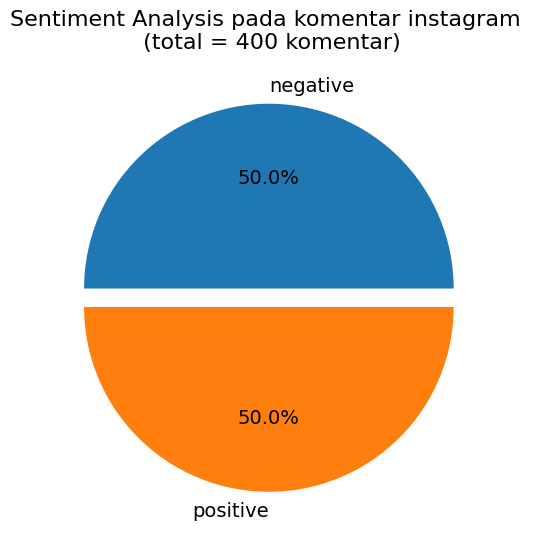

In [ ]:
# visualisasi distribusi komentar negatif dan positif
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['sentiment'].value_counts()]
labels = list(df['sentiment'].value_counts().index)
explode = (0.1, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Analysis pada komentar instagram \n (total = 400 komentar)', fontsize = 16, pad = 20)
plt.show()

In [ ]:
from collections import Counter

# Assuming tokenized_corpus is your list of tokenized texts
# Flatten the list of tokenized words
all_words = [word for sublist in tokenized_corpus for word in sublist]

# Count the occurrences of each word
word_counts = Counter(all_words)

# If you want to convert it to a dictionary
word_counts_dict = dict(word_counts)


In [ ]:
word_counts_dict

{'tolol': 7,
 'hubung': 3,
 'gugur': 1,
 'dgn': 8,
 'pake': 22,
 'hijab': 2,
 'syar': 1,
 'i': 1,
 'bilang': 20,
 'bayi': 1,
 'panas': 3,
 'dalem': 1,
 'woyyyy': 1,
 'otak': 20,
 'jempol': 1,
 'singkron': 1,
 'nulis': 1,
 'komentar': 2,
 'geblek': 1,
 'tata': 4,
 'cowo': 5,
 'balik': 3,
 'hadeww': 1,
 'ntar': 4,
 'tinggal': 5,
 'nyalahin': 1,
 'tuh': 15,
 'kitenya': 1,
 'oon': 1,
 'kmrn': 5,
 'skr': 1,
 'lengket': 1,
 'duhhh': 1,
 'labil': 1,
 'mbak': 25,
 'kya': 3,
 'abege': 2,
 'ajah': 5,
 'ato': 2,
 'cari': 8,
 'sensasi': 5,
 'biar': 24,
 'top': 3,
 'markotoppp': 1,
 'ertong': 4,
 'gk': 10,
 'kualitas': 3,
 'inti': 1,
 'kesel': 1,
 'att': 13,
 'gausah': 1,
 'anak': 18,
 'kasi': 8,
 'kembang': 1,
 'psikis': 1,
 'depan': 3,
 'bener': 12,
 'anda': 2,
 'dikatain': 1,
 'benci': 8,
 'gimana': 6,
 'asa': 4,
 'batesnya': 1,
 'nama': 11,
 'manusia': 20,
 'gaakan': 1,
 'suka': 32,
 'haters': 2,
 'hadewwwww': 1,
 'permpuan': 2,
 'sakit': 9,
 'jiwa': 3,
 'knp': 4,
 'peran': 1,
 'utama': 3,
 'fi

## Word Cloud

In [ ]:
# visualisasi kata yang sering muncul dengan Word Cloud

# memisahkan kolom sentimen dengan text
text_column = 'text_processed'
sentiment_column = 'sentiment'

# Pisahkan komentar berdasarkan sentimen
positive_comments = ' '.join(df[df[sentiment_column] == 'positive'][text_column].dropna().astype(str))
negative_comments = ' '.join(df[df[sentiment_column] == 'negative'][text_column].dropna().astype(str))

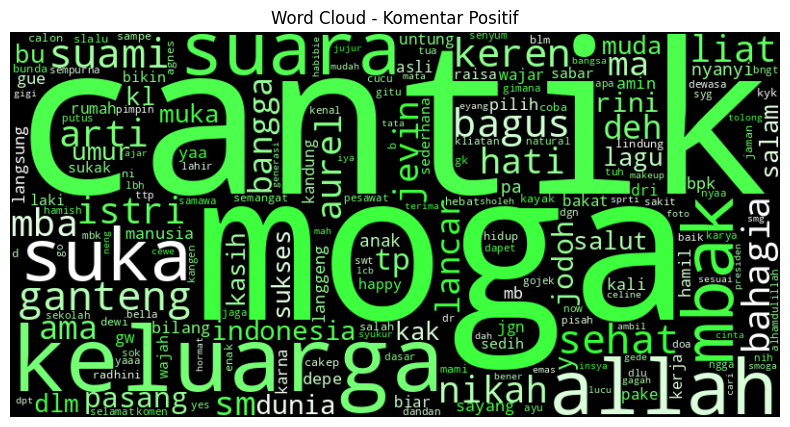

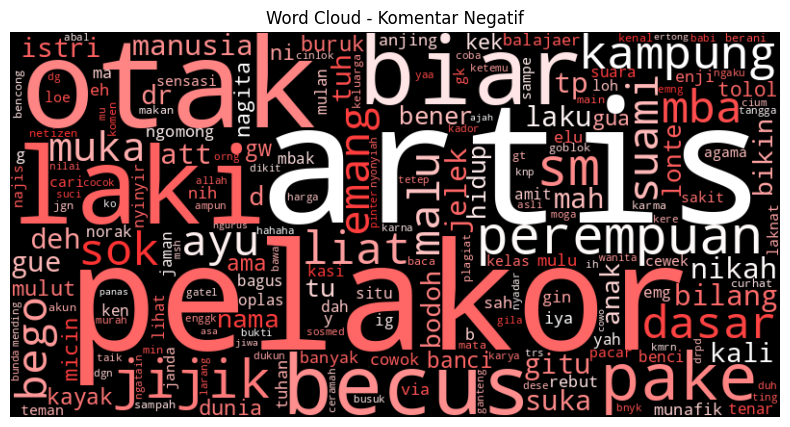

In [ ]:
# Membuat fungsi untuk menampilkan Word Cloud
def create_wordcloud(text, title, color_func):
    wordcloud = WordCloud(width=800, height=400, background_color='black', collocations=False, color_func=color_func).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Fungsi warna untuk komentar negatif warna merah
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%, {}%)".format(random_state.randint(60, 100))

# Fungsi warna untuk komentar positif warna hijau
def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(120, 100%, {}%)".format(random_state.randint(60, 100))

# Membuat word cloud untuk komentar positif
create_wordcloud(positive_comments, 'Word Cloud - Komentar Positif', green_color_func)

# Membuat word cloud untuk komentar negatif
create_wordcloud(negative_comments, 'Word Cloud - Komentar Negatif', red_color_func)

### ** Model Building**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text_processed'].values)
X = tokenizer.texts_to_sequences(df['text_processed'].values)
X = pad_sequences(X)
X[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 135, 373, 893, 112,  21, 537, 894,
        895,  24, 896, 374, 897, 373, 898,  25, 899, 900, 901, 538],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        902, 288, 211, 375, 903, 289, 212, 904,  47, 211, 905, 906]],
      dtype=int32)

In [ ]:
y = df['label']

In [ ]:
X.shape

(400, 77)

In [ ]:
y.shape

(400,)

In [ ]:
#split training dan test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(320, 77) (320,)
(80, 77) (80,)


## Model Architecture Definition & Training

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
!pip install keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
embed_dim = 128
lstm_out = 64

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(lstm_out // 2, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=800, validation_data=(X_test, y_test), verbose=2)

Epoch 1/25
1/1 - 16s - loss: 0.6938 - accuracy: 0.4844 - val_loss: 0.6913 - val_accuracy: 0.4750 - 16s/epoch - 16s/step
Epoch 2/25
1/1 - 2s - loss: 0.6896 - accuracy: 0.5781 - val_loss: 0.6894 - val_accuracy: 0.4500 - 2s/epoch - 2s/step
Epoch 3/25
1/1 - 2s - loss: 0.6863 - accuracy: 0.5531 - val_loss: 0.6872 - val_accuracy: 0.4500 - 2s/epoch - 2s/step
Epoch 4/25
1/1 - 2s - loss: 0.6820 - accuracy: 0.5250 - val_loss: 0.6846 - val_accuracy: 0.4625 - 2s/epoch - 2s/step
Epoch 5/25
1/1 - 2s - loss: 0.6785 - accuracy: 0.5437 - val_loss: 0.6813 - val_accuracy: 0.4625 - 2s/epoch - 2s/step
Epoch 6/25
1/1 - 2s - loss: 0.6731 - accuracy: 0.5719 - val_loss: 0.6772 - val_accuracy: 0.4875 - 2s/epoch - 2s/step
Epoch 7/25
1/1 - 3s - loss: 0.6689 - accuracy: 0.6125 - val_loss: 0.6724 - val_accuracy: 0.5000 - 3s/epoch - 3s/step
Epoch 8/25
1/1 - 2s - loss: 0.6627 - accuracy: 0.6375 - val_loss: 0.6671 - val_accuracy: 0.5500 - 2s/epoch - 2s/step
Epoch 9/25
1/1 - 2s - loss: 0.6518 - accuracy: 0.6875 - val_l

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 128)           256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 77, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 77, 64)            49408     
                                                                 
 spatial_dropout1d_1 (Spati  (None, 77, 64)            0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 3

## Model Evaluation

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 23ms/step - loss: 0.3796 - accuracy: 0.7750


[0.37963950634002686, 0.7749999761581421]

In [ ]:
preds = model.predict(X_test)



3/3 [==============================] - 1s 44ms/step


In [ ]:
from sklearn.metrics import classification_report

binary_preds = (preds > 0.5).astype(int)
report = classification_report(y_test, binary_preds)

print(report)

              precision    recall  f1-score   support

           0       0.86      0.70      0.78        44
           1       0.70      0.86      0.78        36

    accuracy                           0.78        80
   macro avg       0.78      0.78      0.78        80
weighted avg       0.79      0.78      0.78        80



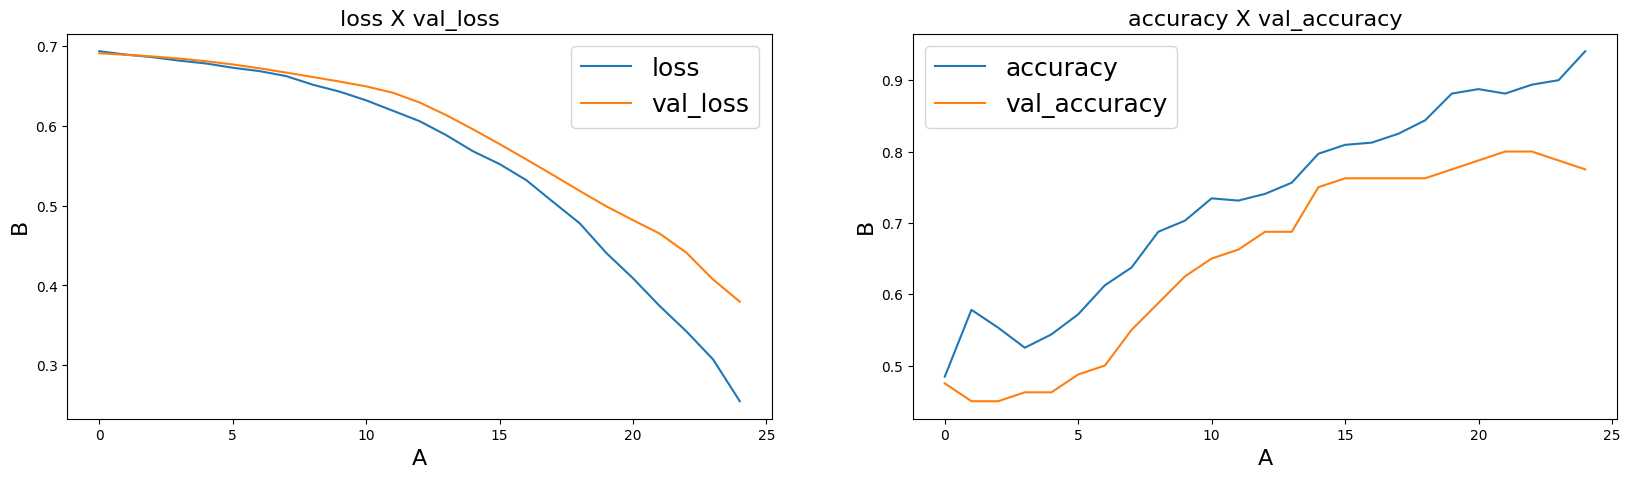

In [ ]:

def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)


plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

## Save Model

In [ ]:
# Menyimpan model kedalam H5
model.save('model.h5')

!tar -zcvf model.h5.tgz model.h5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model.h5


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Misalkan tokenizer dan model sudah tersedia
# tokenizer = ...

# Teks yang ingin diprediksi
new_texts = [
    "ngaca bang muka lo kek babi",
    "liat bini lo pelakor anjing",
    "ganteng banget dah suami lo",
    "cantik banget anak ku"
]

# Tokenisasi teks
sequences = tokenizer.texts_to_sequences(new_texts)

# Pad sequences sesuai dengan input_length yang digunakan dalam model
maxlen = X.shape[1]  # X.shape[1] adalah panjang input yang digunakan dalam model
X_new = pad_sequences(sequences, maxlen=30)
X_new



array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 729,
        517,  22,  65, 309],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          7, 477,  23, 144],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  20, 101,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   3,  32, 711]], dtype=int32)

In [ ]:

# Prediksi menggunakan model
new_texts_preds = model.predict(X_new)

# Konversi prediksi menjadi binary (0 atau 1)
binary_pred = (new_texts_preds > 0.7).astype(int)

# Print hasil prediksi
for i in range(len(new_texts)):
    print(f"Text: {new_texts[i]}. {'Negative ❌' if binary_pred[i] == 0 else 'Positive ✅'}")

1/1 [==============================] - 1s 1s/step
Text: ngaca bang muka lo kek babi. Negative ❌
Text: liat bini lo pelakor anjing. Positive ✅
Text: ganteng banget dah suami lo. Positive ✅
Text: cantik banget anak ku. Positive ✅


# Conclusion

Dari analisa yang telah dilakukan didapatkan asumsi berikut :


Dengan akurasi sebesar 88%, model analisis sentimen ini cukup andal untuk digunakan dalam berbagai aplikasi, seperti analisis ulasan produk, pemantauan media sosial, dan survei kepuasan pelanggan. Namun, perlu diingat bahwa meskipun akurasi tinggi, masih ada 12% kemungkinan bahwa prediksi bisa salah. Oleh karena itu, interpretasi hasil prediksi harus dilakukan dengan mempertimbangkan kemungkinan kesalahan dan, jika perlu, dilakukan verifikasi tambahan dengan metode lain.


Model ini dapat membantu perusahaan dan individu dalam memahami persepsi publik terhadap produk, layanan, atau topik tertentu, sehingga dapat membuat keputusan yang lebih baik berdasarkan data sentimen yang terukur.